<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Gradient_Centralization_for_Better_Training_Performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install tensorflow-datasets


In [ ]:
from time import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [ ]:
num_classes = 2
input_shape = (300, 300, 3)
dataset_name = "horses_or_humans"
batch_size = 128
AUTOTUNE = tf.data.experimental.AUTOTUNE

(train_ds, test_ds), metadata = tfds.load(
    name=dataset_name,
    split=[tfds.Split.TRAIN, tfds.Split.TEST],
    with_info=True,
    as_supervised=True,
)


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incomplete44GG1B/horses_or_humans-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/horses_or_humans/3.0.0.incomplete44GG1B/horses_or_humans-test.tfrecord


Dataset horses_or_humans downloaded and prepared to /root/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


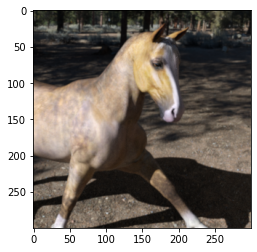

In [ ]:
import matplotlib.pyplot as plt

a = next(iter(train_ds))
plt.imshow(next(iter(train_ds))[0])

In [ ]:
metadata.features['image']

Image(shape=(300, 300, 3), dtype=tf.uint8)

In [ ]:
metadata

tfds.core.DatasetInfo(
    name='horses_or_humans',
    version=3.0.0,
    description='A large set of images of horses and humans.',
    homepage='http://laurencemoroney.com/horses-or-humans-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=1283,
    splits={
        'test': 256,
        'train': 1027,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {horses_or_humans,
    author = "Laurence Moroney",
    title = "Horses or Humans Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/horses-or-humans-dataset"
    }""",
    redistribution_info=,
)

In [ ]:
image = []
for i in train_ds.take(10):
  image.append(i[0])


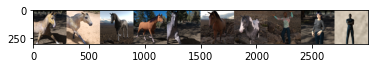

In [ ]:
images = tf.concat(image, axis=1)
plt.imshow(images)


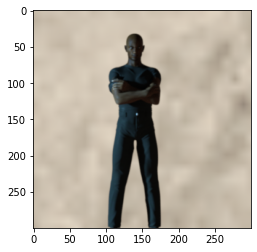

In [ ]:
plt.imshow(image[9])

In [ ]:
rescale = layers.experimental.preprocessing.Rescaling(1.0 / 255)

data_augmentation = tf.keras.Sequential([
                                         layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
                                         layers.experimental.preprocessing.RandomRotation(0.3),
                                         layers.experimental.preprocessing.RandomZoom(0.2)
])

def prepare(ds, shuffle = False, augment = False):
  ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls = AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1024)

  # batch dataset
  ds = ds.batch(batch_size)

  # use data augmentation only on the training set 
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training = True), y))

    return ds.prefetch(buffer_size = AUTOTUNE)

In [ ]:
train_ds = prepare(train_ds, shuffle=True, augment = True)
test_ds = prepare(test_ds)

In [ ]:
model = tf.keras.Sequential(
    [
        layers.Conv2D(16, (3, 3), activation="relu", input_shape=(300, 300, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(32, (3, 3), activation="relu"),
        layers.Dropout(0.5),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.Dropout(0.5),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation="relu"),
        layers.MaxPooling2D(2, 2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(512, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
class GCRMSprop(RMSprop):
    def get_gradients(self, loss, params):
        # We here just provide a modified get_gradients() function since we are
        # trying to just compute the centralized gradients.

        grads = []
        gradients = super().get_gradients()
        for grad in gradients:
            grad_len = len(grad.shape)
            if grad_len > 1:
                axis = list(range(grad_len - 1))
                grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
            grads.append(grad)

        return grads


optimizer = GCRMSprop(learning_rate=1e-4)

In [ ]:
class TimeHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs = {}):
    self.epoch_time_start = time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time()-self.epoch_time_start)



In [ ]:
time_callback_no_gc = TimeHistory()
model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=["accuracy"],
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 71, 64)       

In [ ]:
history_no_gc = model.fit(
    train_ds, epochs=10, verbose=1, callbacks=[time_callback_no_gc]
)

Epoch 1/10
9/9 [==============================] - 55s 2s/step - loss: 0.7267 - accuracy: 0.5229
Epoch 2/10
9/9 [==============================] - 22s 2s/step - loss: 0.6765 - accuracy: 0.5794
Epoch 3/10
9/9 [==============================] - 22s 2s/step - loss: 0.6842 - accuracy: 0.5949
Epoch 4/10
9/9 [==============================] - 22s 2s/step - loss: 0.6578 - accuracy: 0.6378
Epoch 5/10
9/9 [==============================] - 22s 2s/step - loss: 0.6328 - accuracy: 0.6806
Epoch 6/10
9/9 [==============================] - 22s 2s/step - loss: 0.6433 - accuracy: 0.6806
Epoch 7/10
9/9 [==============================] - 22s 2s/step - loss: 0.6087 - accuracy: 0.6943
Epoch 8/10
9/9 [==============================] - 22s 2s/step - loss: 0.5960 - accuracy: 0.7001
Epoch 9/10
9/9 [==============================] - 22s 2s/step - loss: 0.6516 - accuracy: 0.7244
Epoch 10/10
9/9 [==============================] - 22s 2s/step - loss: 0.5318 - accuracy: 0.7614


In [ ]:
time_callback_gc = TimeHistory()
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

history_gc = model.fit(train_ds, epochs=10, verbose=1, callbacks=[time_callback_gc])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 71, 71, 64)       

In [ ]:
print("Not using Gradient Centralization")
print(f"Loss: {history_no_gc.history['loss'][-1]}")
print(f"Accuracy: {history_no_gc.history['accuracy'][-1]}")
print(f"Training Time: {sum(time_callback_no_gc.times)}")

print("Using Gradient Centralization")
print(f"Loss: {history_gc.history['loss'][-1]}")
print(f"Accuracy: {history_gc.history['accuracy'][-1]}")
print(f"Training Time: {sum(time_callback_gc.times)}")

Not using Gradient Centralization
Loss: 0.5317569375038147
Accuracy: 0.7614411115646362
Training Time: 253.81955480575562
Using Gradient Centralization
Loss: 0.3831477165222168
Accuracy: 0.8364167213439941
Training Time: 221.20794463157654
